In [26]:
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

The dataset is here: https://www.kaggle.com/datasets/nehaprabhavalkar/av-healthcare-analytics-ii


The aim of the dataset is to predict hospital length of stay - which is represented by the ``stay`` column. Interesting it is discretized into 11 different categories. 
The question is to treat as classification or as an ordinal regression task.....

In [16]:
df_dictionary = pd.read_csv('../data/train_data_dictionary.csv')

In [10]:
df_dictionary

,Column,Description
0,case_id,Case_ID registered in Hospital
1,Hospital_code,Unique code for the Hospital
2,Hospital_type_code,Unique code for the type of Hospital
3,City_Code_Hospital,City Code of the Hospital
4,Hospital_region_code,Region Code of the Hospital
5,Available Extra Rooms in Hospital,Number of Extra rooms available in the Hospital
6,Department,Department overlooking the case
7,Ward_Type,Code for the Ward type
8,Ward_Facility_Code,Code for the Ward Facility
9,Bed Grade,Condition of Bed in the Ward


In [45]:
df = pd.read_csv('../data/train_data.csv')
df

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,a,6,X,3,radiotherapy,Q,F,4.0,86499,23.0,Emergency,Moderate,3,41-50,4144.0,11-20
318434,318435,24,a,1,X,2,anesthesia,Q,E,4.0,325,8.0,Urgent,Moderate,4,81-90,6699.0,31-40
318435,318436,7,a,4,X,3,gynecology,R,F,4.0,125235,10.0,Emergency,Minor,3,71-80,4235.0,11-20
318436,318437,11,b,2,Y,3,anesthesia,Q,D,3.0,91081,8.0,Trauma,Minor,5,11-20,3761.0,11-20


In [46]:
# Turning target column into a numeric option
df['Stay_numeric'] = df['Stay'].map(
{'0-10': 1,
'11-20': 2,
'21-30': 3,
'31-40': 4,
'41-50': 5,
'51-60': 6,
'61-70': 7,
'71-80': 8,
'81-90': 9,
'91-100': 10,
'More than 100 Days':11})

# Dichotomise into admitted for Longer then 30 days or not
df['long_stay'] = df['Stay_numeric']>3
df['long_stay'] = df['long_stay'].replace({True:1, False:0})

In [47]:
df['long_stay'].value_counts()

0    189234
1    129204
Name: long_stay, dtype: int64

In [19]:
df.describe()

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Visitors with Patient,Admission_Deposit
count,318438.000000,318438.000000,318438.000000,318438.000000,318325.000000,318438.000000,313906.000000,318438.000000,318438.000000
mean,159219.500000,18.318841,4.771717,3.197627,2.625807,65747.579472,7.251859,3.284099,4880.749392
std,91925.276848,8.633755,3.102535,1.168171,0.873146,37979.936440,4.745266,1.764061,1086.776254
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1800.000000
25%,79610.250000,11.000000,2.000000,2.000000,2.000000,32847.000000,4.000000,2.000000,4186.000000
50%,159219.500000,19.000000,5.000000,3.000000,3.000000,65724.500000,8.000000,3.000000,4741.000000
75%,238828.750000,26.000000,7.000000,4.000000,3.000000,98470.000000,8.000000,4.000000,5409.000000
max,318438.000000,32.000000,13.000000,24.000000,4.000000,131624.000000,38.000000,32.000000,11008.000000


In [21]:
# target colum
df.groupby('Stay')['Stay'].count()

Stay
0-10                  23604
11-20                 78139
21-30                 87491
31-40                 55159
41-50                 11743
51-60                 35018
61-70                  2744
71-80                 10254
81-90                  4838
91-100                 2765
More than 100 Days     6683
Name: Stay, dtype: int64

/tmp/ipykernel_3912/4089211283.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


<Axes: >

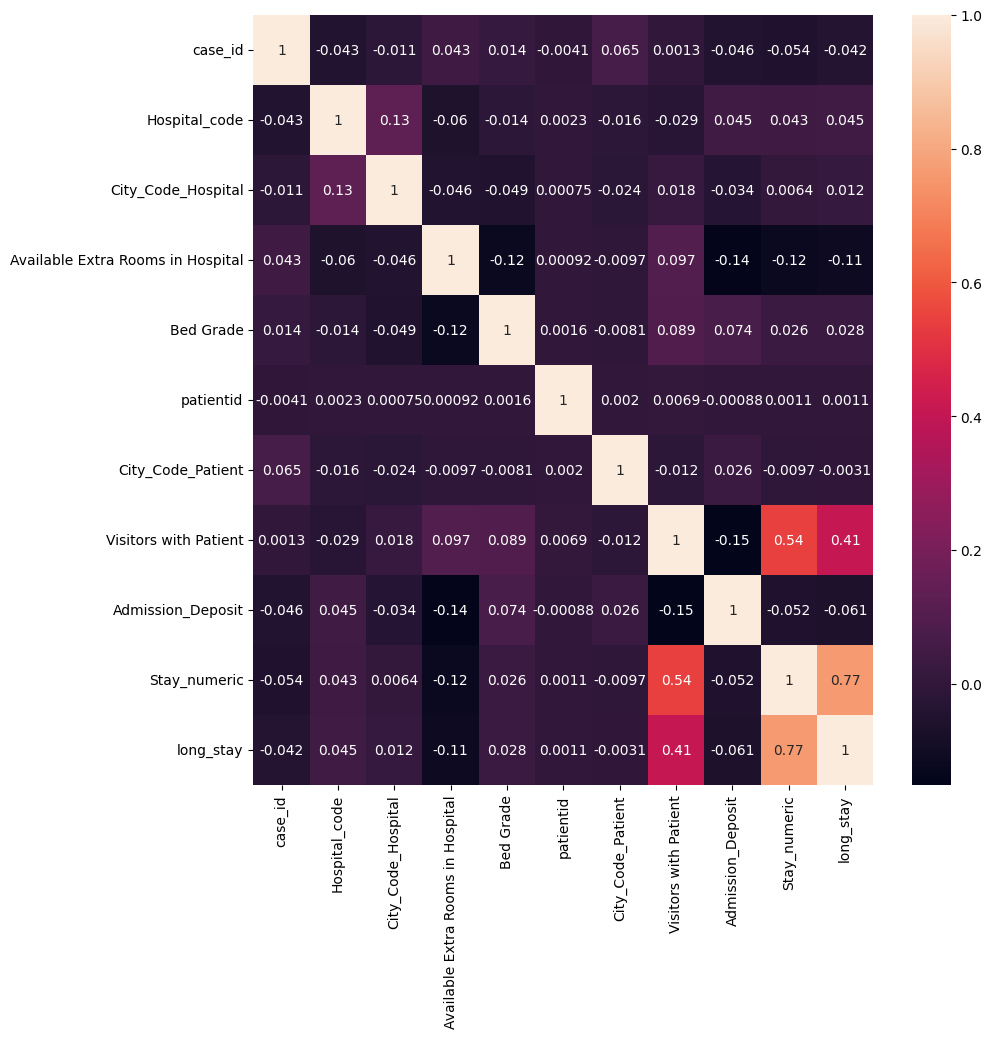

In [48]:
# Calculate correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix,annot=True)


<Axes: >

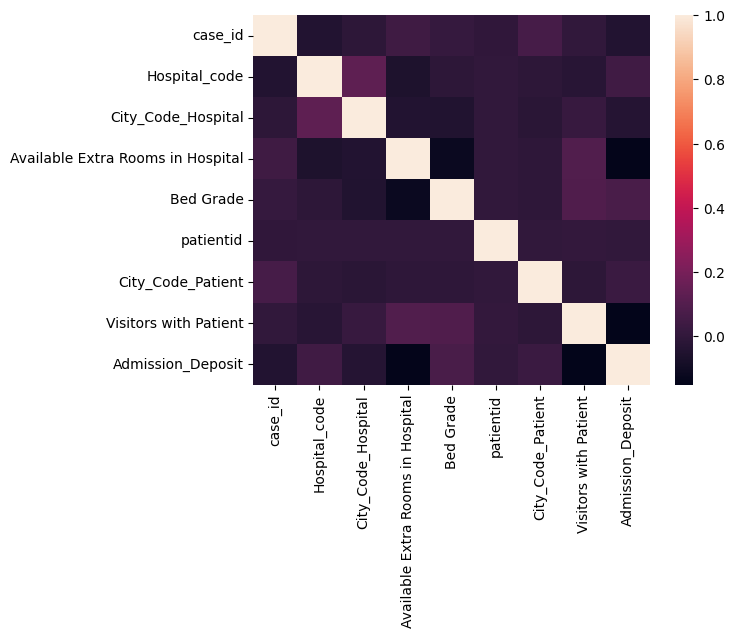